Denoising rows: 100%|██████████| 512/512 [09:58<00:00,  1.17s/it]



Pixel count: 262144
PSNR (noisy):    20.021 dB
PSNR (denoised): 17.763 dB


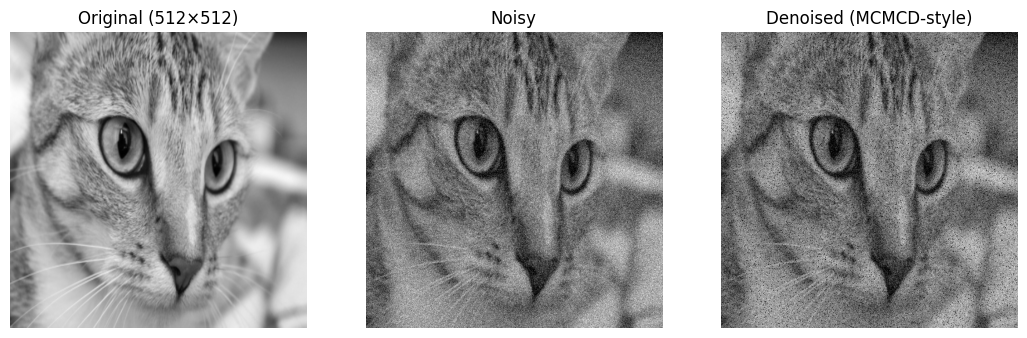

In [ ]:
# MCMCD-style image denoising (Jupyter-ready, with progress bars)
# ---------------------------------------------------------------
# Config:
IMAGE_PATH = None            # e.g. "my_photo.jpg" (in same folder). If None, a random image is used.
OUTPUT_SIZE = 512            # final working size (use 512 as requested)
SIGMA_NOISE = 0.10           # noise std on [0,1] scale (~0.10 ≈ 25/255)
K_SAMPLES   = 200            # samples per pixel (increase for better quality, but it's slower)
PATCH_R     = 2              # patch radius: 1 -> 3x3, 2 -> 5x5
SIGMA_S     = 3            # spatial sampling std (pixels)
RNG_SEED    = 0

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import io, color, transform, data
from scipy.ndimage import uniform_filter

# ---------- Helpers ----------
def to_float01(img):
    img = img.astype(np.float32)
    if img.max() > 1.5:
        img /= 255.0
    return np.clip(img, 0.0, 1.0)

def psnr(gt, est):
    mse = np.mean((gt - est) ** 2)
    if mse == 0:
        return 99.0
    return 10.0 * np.log10(1.0 / mse)

def load_image_1024(image_path=None, size=1024, rng=None):
    if image_path is not None:
        img = io.imread(image_path)
    else:
        # pick a random built-in image
        choices = [
            data.camera(),      # gray
            data.astronaut(),   # color
            data.coffee(),      # color
            data.chelsea(),     # color
        ]
        idx = rng.integers(0, len(choices))
        img = choices[idx]
    # to grayscale
    if img.ndim == 3:
        img = color.rgb2gray(img)
    img = to_float01(img)
    # resize to exactly size×size
    img = transform.resize(img, (size, size), order=1, mode='reflect', anti_aliasing=True)
    return img

def pad_reflect(img, r):
    return np.pad(img, r, mode="reflect")

def extract_patch(padded, x, y, r):
    return padded[x:x+2*r+1, y:y+2*r+1]

def geman_mcclure_weight(p_ref, p_cand, sigma_n, s_local):
    # Eq. inspired weighting on patch difference
    diff2  = (p_cand - p_ref) ** 2
    denom  = (sigma_n**2) * (s_local**2) + diff2
    return np.exp(-np.sum(diff2 / denom))

def mcmcd_importance_denoise(noisy, K=32, r=1, sigma_s=3.0, sigma_n=0.08, seed=0):
    """
    Importance-weighted sampler (no accept/reject for speed/stability).
    For each pixel s, draw K candidate sites from N(s, sigma_s^2 I),
    weight by Geman–McClure patch similarity, return weighted mean intensity.
    """
    H, W = noisy.shape
    den = np.zeros_like(noisy, dtype=np.float32)
    padded = pad_reflect(noisy, r)

    # local variance map (rough; used as s_local)
    mu  = uniform_filter(noisy, size=2*r+1, mode='reflect')
    var = uniform_filter(noisy**2, size=2*r+1, mode='reflect') - mu**2
    var = np.clip(var, 1e-6, None)
    s_local = np.sqrt(var)

    rng = np.random.default_rng(seed)

    for x in tqdm(range(H), desc="Denoising rows", leave=True):
        for y in range(W):
            pref = extract_patch(padded, x, y, r)
            s_loc = s_local[x, y]

            dx = rng.normal(0.0, sigma_s, size=K)
            dy = rng.normal(0.0, sigma_s, size=K)
            xs = np.clip((x + dx).astype(int), 0, H-1)
            ys = np.clip((y + dy).astype(int), 0, W-1)

            weights = np.empty(K, dtype=np.float32)
            vals    = np.empty(K, dtype=np.float32)
            for i in range(K):
                pc = extract_patch(padded, xs[i], ys[i], r)
                weights[i] = geman_mcclure_weight(pref, pc, sigma_n, s_loc)
                vals[i]    = noisy[xs[i], ys[i]]

            wsum = np.sum(weights) + 1e-12
            den[x, y] = float(np.sum(weights * vals) / wsum)

    return den

# ---------- Load / prepare ----------
rng = np.random.default_rng(RNG_SEED)
orig = load_image_1024(IMAGE_PATH, size=OUTPUT_SIZE, rng=rng)
pixels = orig.size

# ---------- Add Gaussian noise ----------
noisy = np.clip(orig + rng.normal(0, SIGMA_NOISE, orig.shape).astype(np.float32), 0, 1)

# ---------- Denoise ----------
denoised = mcmcd_importance_denoise(
    noisy,
    K=K_SAMPLES,
    r=PATCH_R,
    sigma_s=SIGMA_S,
    sigma_n=SIGMA_NOISE,
    seed=RNG_SEED
)

# ---------- Report + show ----------
print(f"Pixel count: {pixels}")
print(f"PSNR (noisy):    {psnr(orig, noisy):.3f} dB")
print(f"PSNR (denoised): {psnr(orig, denoised):.3f} dB")

fig, axes = plt.subplots(1, 3, figsize=(13,4))
axes[0].imshow(orig, cmap='gray');    axes[0].set_title("Original (512×512)"); axes[0].axis('off')
axes[1].imshow(noisy, cmap='gray');   axes[1].set_title("Noisy");              axes[1].axis('off')
axes[2].imshow(denoised, cmap='gray');axes[2].set_title("Denoised (MCMCD-style)"); axes[2].axis('off')
plt.show()


Denoising rows: 100%|█████████████████████████| 512/512 [04:40<00:00,  1.83it/s]



PSNR noisy:    20.02 dB
PSNR denoised: 21.26 dB


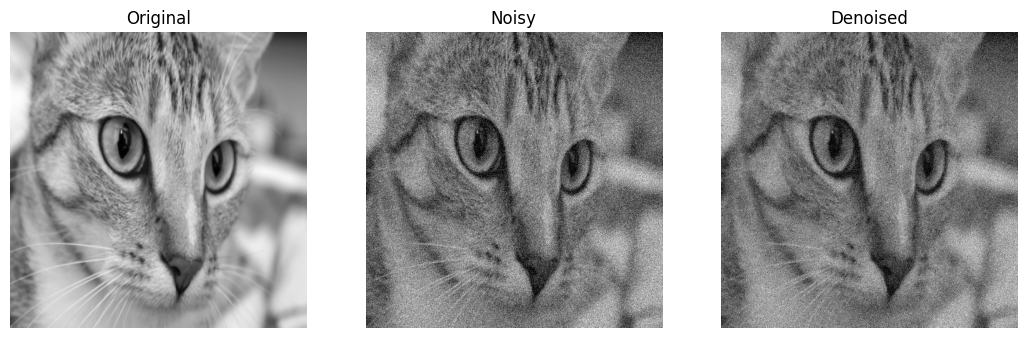

In [ ]:
# MCMCD-style image denoising (fixed patch indexing + stable weights)
# -------------------------------------------------------------------
IMAGE_PATH = None          # e.g. "my_photo.jpg"; if None, a random image is used
OUTPUT_SIZE = 512
SIGMA_NOISE = 0.10         # noise std in [0,1] scale (~25/255)
K_SAMPLES   = 128          # try 128–384 for stronger denoising (slower if larger)
PATCH_R     = 2            # 2 => 5x5 patches; try 3 => 7x7 for more context
SIGMA_S     = 4.0          # spatial sampling std in pixels (try 3–6)
RNG_SEED    = 0
VERBOSE_PBAR = True

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import io, color, transform, data
from scipy.ndimage import uniform_filter

def to_float01(img):
    img = img.astype(np.float32)
    if img.max() > 1.5:
        img /= 255.0
    return np.clip(img, 0.0, 1.0)

def psnr(gt, est):
    mse = np.mean((gt - est) ** 2)
    return 99.0 if mse == 0 else 10.0 * np.log10(1.0 / mse)

def load_gray_square(image_path=None, size=512, rng=None):
    if image_path is not None:
        img = io.imread(image_path)
    else:
        # choose a random sample image
        choices = [data.camera(), data.astronaut(), data.coffee(), data.chelsea()]
        img = choices[rng.integers(0, len(choices))]
    if img.ndim == 3:
        img = color.rgb2gray(img)
    img = to_float01(img)
    img = transform.resize(img, (size, size), order=1, mode='reflect', anti_aliasing=True)
    return img

def pad_reflect(img, r):
    return np.pad(img, r, mode="reflect")

def extract_patch(padded, x, y, r):
    """Correctly center at (x,y) in original by offsetting into padded by +r."""
    X = x + r
    Y = y + r
    return padded[X - r:X + r + 1, Y - r:Y + r + 1]

def geman_mcclure_weight(p_ref, p_cand, sigma_n, s_local, eps=1e-12):
    diff2 = (p_cand - p_ref)**2
    # correct-ish form matching the paper’s adaptive Geman–McClure idea
    term = (diff2 / (sigma_n**4 + eps)) / (s_local**2 + diff2 + eps)
    return float(np.exp(-np.sum(term)))


def mcmcd_importance_denoise(noisy, K=128, r=2, sigma_s=4.0, sigma_n=0.10, seed=0, verbose=True):
    H, W = noisy.shape
    out = np.zeros_like(noisy, dtype=np.float32)
    padded = pad_reflect(noisy, r)

    # local variance map (used as s_local)
    win = 2*r + 1
    mu  = uniform_filter(noisy, size=win, mode='reflect')
    var = uniform_filter(noisy**2, size=win, mode='reflect') - mu**2
    var = np.clip(var, 1e-6, None)
    s_local = np.sqrt(var)

    rng = np.random.default_rng(seed)
    rows_iter = tqdm(range(H), desc="Denoising rows", ncols=80, disable=not verbose)

    for x in rows_iter:
        for y in range(W):
            p_ref = extract_patch(padded, x, y, r)
            s_loc = s_local[x, y]

            # sample K candidate coordinates from N([x,y], sigma_s^2 I)
            dx = rng.normal(0.0, sigma_s, size=K)
            dy = rng.normal(0.0, sigma_s, size=K)
            xs = np.clip((x + dx).astype(int), 0, H-1)
            ys = np.clip((y + dy).astype(int), 0, W-1)

            # compute log-weights to avoid exp underflow
            logw = np.empty(K, dtype=np.float32)
            vals = np.empty(K, dtype=np.float32)
            for i in range(K):
                p_cand = extract_patch(padded, xs[i], ys[i], r)
                logw[i] = geman_mcclure_weight(p_ref, p_cand, sigma_n, s_loc)
                vals[i] = noisy[xs[i], ys[i]]

            # stabilize: subtract max before exp and normalize
            logw -= np.max(logw)
            w = np.exp(logw)
            w_sum = np.sum(w) + 1e-12
            w /= w_sum

            # conditional mean estimate
            out[x, y] = float(np.sum(w * vals))

    return out

# --------- Run ----------
rng = np.random.default_rng(RNG_SEED)
orig  = load_gray_square(IMAGE_PATH, size=OUTPUT_SIZE, rng=rng)
noisy = np.clip(orig + rng.normal(0, SIGMA_NOISE, orig.shape).astype(np.float32), 0, 1)

denoised = mcmcd_importance_denoise(
    noisy,
    K=K_SAMPLES,
    r=PATCH_R,
    sigma_s=SIGMA_S,
    sigma_n=SIGMA_NOISE,
    seed=RNG_SEED,
    verbose=VERBOSE_PBAR
)

print(f"PSNR noisy:    {psnr(orig, noisy):.2f} dB")
print(f"PSNR denoised: {psnr(orig, denoised):.2f} dB")

fig, ax = plt.subplots(1,3, figsize=(13,4))
ax[0].imshow(orig, cmap='gray');    ax[0].set_title("Original"); ax[0].axis('off')
ax[1].imshow(noisy, cmap='gray');   ax[1].set_title("Noisy");    ax[1].axis('off')
ax[2].imshow(denoised, cmap='gray');ax[2].set_title("Denoised"); ax[2].axis('off')
plt.show()


Denoising rows: 100%|███████████████████████████████████| 512/512 [13:42<00:00,  1.61s/it]



Estimated noise σ_n: 0.1973 (true 0.2)
PSNR (noisy):    14.25 dB
PSNR (denoised): 14.39 dB


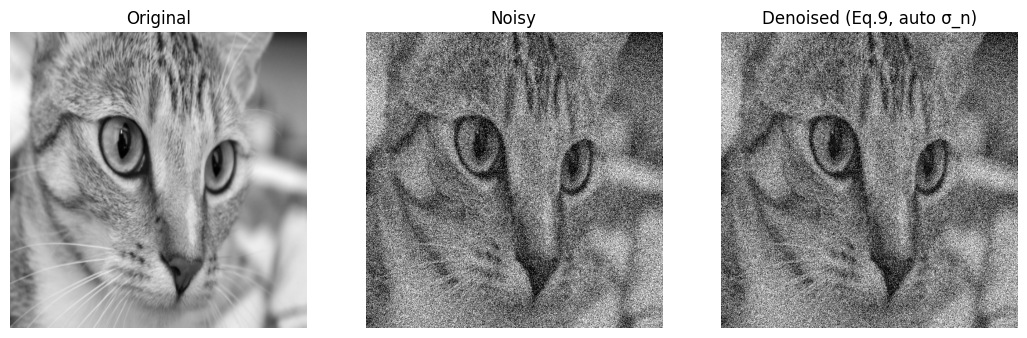

In [11]:
# MCMCD-style denoising (paper-faithful weight + automatic sigma_n)
# -----------------------------------------------------------------
# Changes vs earlier:
#  • Weight φ matches Eq. (9):  Π_j exp( - Δ^2 / (σ_n^4 / σ_l^2 + Δ^2) )
#  • σ_n is estimated from the noisy image (robust MAD-on-differences)
#  • Circular patches (radius r ⇒ (2r+1)x(2r+1) with a disk mask)
#  • Progress bars; Jupyter-friendly

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import io, color, transform, data

# ----------------- Config -----------------
IMAGE_PATH   = None        # e.g. "my_photo.jpg" in same folder; if None, uses a built-in image
WORK_SIZE    = 512         # use 256 for speed in notebooks; 512 is slower but nicer
K_SAMPLES    = 200         # samples per pixel (↑ = better but slower). Try 128–256
PATCH_R      = 3           # circular patch radius (paper used r≈3)
SIGMA_S      = 3.0         # spatial proposal std (pixels). 2.5–4.0 is a good range
RNG_SEED     = 0           # for reproducibility
ADD_NOISE    = True        # set False if you bring your own already-noisy image
TRUE_SIGMA   = 0.2        # only used if ADD_NOISE=True (noise added in [0,1] range)

# -------------- Small helpers --------------
def to_float01(img):
    img = img.astype(np.float32)
    if img.ndim == 3 and img.shape[2] == 3:
        img = color.rgb2gray(img)
    if img.max() > 1.5:
        img = img / 255.0
    return np.clip(img, 0.0, 1.0)

def load_image(image_path=None, size=256, rng=None):
    if image_path:
        img = io.imread(image_path)
    else:
        # pick a built-in image at random to avoid bias
        choices = [data.camera(), data.astronaut(), data.coffee(), data.chelsea()]
        img = choices[rng.integers(0, len(choices))]
    img = to_float01(img)
    if size is not None:
        img = transform.resize(img, (size, size), order=1, mode='reflect', anti_aliasing=True)
    return img

def psnr(gt, est):
    mse = np.mean((gt - est) ** 2)
    return 99.0 if mse == 0 else 10.0 * np.log10(1.0 / mse)

def estimate_noise_sigma(image):
    """
    Robust σ_n (std) from first differences + MAD.
    For i.i.d. Gaussian noise, diff increases variance by 2 ⇒ divide by sqrt(2).
    """
    dh = np.diff(image, axis=1)
    dv = np.diff(image, axis=0)
    diffs = np.concatenate([dh.ravel(), dv.ravel()])
    mad = np.median(np.abs(diffs - np.median(diffs)))
    sigma_hat = (mad / 0.6745) / np.sqrt(2.0)   # MAD->σ, then compensate diff
    return float(max(sigma_hat, 1e-6))

def reflect_pad(img, r):
    return np.pad(img, r, mode="reflect")

def circular_mask(r):
    yy, xx = np.ogrid[-r:r+1, -r:r+1]
    return (xx*xx + yy*yy) <= r*r

def extract_patch(padded, x, y, r, mask=None):
    P = padded[x:x+2*r+1, y:y+2*r+1]
    return P if mask is None else P[mask]

# -------------- Paper Eq.(9) weight --------------
def weight_eq9_patch(reference_patch_flat, candidate_patch_flat, sigma_n, sigma_l):
    """
    φ = Π_j exp( - Δ^2 / (σ_n^4 / σ_l^2 + Δ^2) ), where:
        Δ^2 = (p_cand - p_ref)^2 element-wise (over circular patch entries)
        σ_n is the (estimated) noise std
        σ_l is the local std of the *reference* patch (ρ_{s0})
    """
    diff2 = (candidate_patch_flat - reference_patch_flat) ** 2
    denom_core = (sigma_n**4) / (sigma_l**2 + 1e-12)  # σ_n^4 / σ_l^2
    denom = denom_core + diff2
    # product of exponentials = exp(sum(...)) — stable accumulation
    return float(np.exp(-np.sum(diff2 / denom, dtype=np.float64)))

# -------------- Main denoiser --------------
def mcmcd_importance_denoise(noisy, K=128, r=3, sigma_s=3.0, seed=0):
    """
    Importance-only approximation of Eq.(11):
      For each pixel s:
        - Sample K candidate coordinates from N(s, σ_s^2 I)
        - Weight each sample by Eq.(9) (Geman–McClure objective)
        - Return weighted mean intensity as E[G|F]
    """
    H, W = noisy.shape
    out = np.zeros_like(noisy, dtype=np.float32)
    pad = reflect_pad(noisy, r)
    mask = circular_mask(r)

    # Estimate σ_n from the noisy image (automatic)
    sigma_n = estimate_noise_sigma(noisy)

    rng = np.random.default_rng(seed)

    for x in tqdm(range(H), desc="Denoising rows", ncols=90):
        for y in range(W):
            # reference (circular) patch around s0 = (x,y)
            pref = extract_patch(pad, x, y, r, mask=mask)
            sigma_l = float(np.std(pref, ddof=0))  # local std of ρ_{s0}

            # draw K proposals from a Gaussian around (x,y)
            dx = rng.normal(0.0, sigma_s, size=K)
            dy = rng.normal(0.0, sigma_s, size=K)
            xs = np.clip((x + dx).astype(int), 0, H-1)
            ys = np.clip((y + dy).astype(int), 0, W-1)

            weights = np.empty(K, dtype=np.float32)
            vals    = np.empty(K, dtype=np.float32)

            # gather weighted samples
            for i in range(K):
                pc = extract_patch(pad, xs[i], ys[i], r, mask=mask)
                w  = weight_eq9_patch(pref, pc, sigma_n, sigma_l)
                weights[i] = w
                vals[i] = noisy[xs[i], ys[i]]

            wsum = float(np.sum(weights)) + 1e-12
            out[x, y] = float(np.sum(weights * vals) / wsum)

    return out, sigma_n

# -------------- Demo pipeline --------------
rng = np.random.default_rng(RNG_SEED)

orig = load_image(IMAGE_PATH, size=WORK_SIZE, rng=rng)
if ADD_NOISE:
    noisy = np.clip(orig + rng.normal(0, TRUE_SIGMA, orig.shape).astype(np.float32), 0, 1)
else:
    noisy = orig.copy()

den, sigma_est = mcmcd_importance_denoise(
    noisy,
    K=K_SAMPLES,
    r=PATCH_R,
    sigma_s=SIGMA_S,
    seed=RNG_SEED
)

print(f"Estimated noise σ_n: {sigma_est:.4f}" + (f" (true {TRUE_SIGMA})" if ADD_NOISE else ""))
if ADD_NOISE:
    print(f"PSNR (noisy):    {psnr(orig, noisy):.2f} dB")
    print(f"PSNR (denoised): {psnr(orig, den):.2f} dB")

fig, axes = plt.subplots(1, 3 if ADD_NOISE else 2, figsize=(13,4))
axes[0].imshow(orig, cmap='gray');  axes[0].set_title("Original"); axes[0].axis('off')
axes[1].imshow(noisy, cmap='gray'); axes[1].set_title("Noisy"); axes[1].axis('off')
if ADD_NOISE:
    axes[2].imshow(den, cmap='gray'); axes[2].set_title("Denoised (Eq.9, auto σ_n)"); axes[2].axis('off')
else:
    axes[1].imshow(den, cmap='gray'); axes[1].set_title("Denoised (Eq.9, auto σ_n)"); axes[1].axis('off')
plt.show()


Denoising rows: 100%|███████████████████████████████████| 256/256 [03:30<00:00,  1.21it/s]



Pixel count: 65536
Estimated σ_n: 0.1030 (true 0.1)
PSNR (noisy):    20.03 dB
PSNR (denoised): 20.03 dB


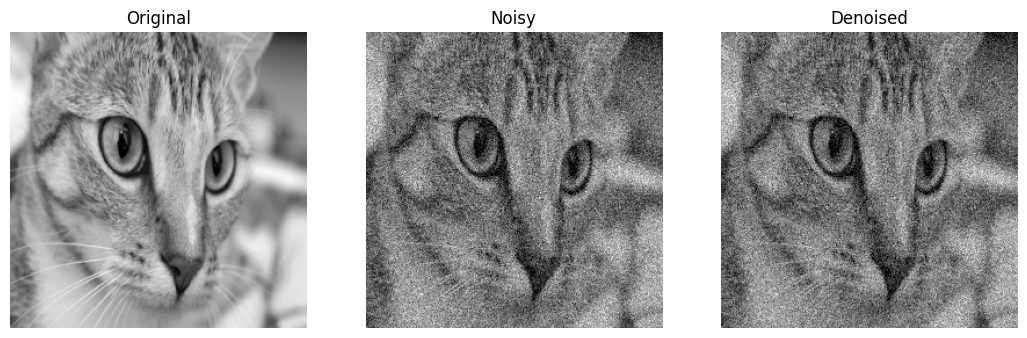

In [12]:
# MCMCD image denoising (Wong et al., 2011) — Jupyter-ready
# -----------------------------------------------------------
# ✔ Exact Eq.(9) weight:
#    φ = ∏_j exp( - Δ_j^2 / (σ_n^4 / σ_ℓ^2 + Δ_j^2) )
#    with Δ_j = F_{r_{s_k'}}(j) - F_{r_{s_0}}(j)
# ✔ σ_n (noise std) is estimated from the noisy image (no reuse of preset)
# ✔ Weighted posterior histogram per pixel (256 bins), conditional mean is output
# ✔ Optional Metropolis–Hastings acceptance (set USE_MH=True)
# ✔ K = 128 samples as requested
# ✔ Reflection padding and circular patches, r = 3 (7×7) by default
# ✔ Progress bars (tqdm)
#
# Notes:
# - This is a faithful, CPU-only reference implementation; it's O(H*W*K*patch^2).
#   On 512×512 it’s slow; try 256×256 first. For faster runs, lower K or r.
# - For reproducibility set RNG_SEED.

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import io, color, data, transform

# -------------------------- Config --------------------------
IMAGE_PATH   = None    # e.g. "my_photo.jpg" (same folder). If None, a random built-in image is used.
WORK_SIZE    = 256     # try 256 first for speed; 512 works but is slow
K_SAMPLES    = 128     # number of proposals per pixel (kept at 128 as requested)
PATCH_R      = 3       # patch radius: 3 -> 7x7; 4 -> 9x9 (more smoothing, slower)
SIGMA_S      = 4.0     # spatial proposal std (pixels). 3–5 generally works well.
USE_MH       = True    # True -> Metropolis–Hastings acceptance; False -> importance-only (faster)
RNG_SEED     = 0

# ---------------------- Utility functions -------------------
def to_float01(img):
    """Return image in float32 [0,1], convert color to gray if needed."""
    img = img.astype(np.float32)
    if img.ndim == 3:
        img = color.rgb2gray(img)
    if img.max() > 1.5:
        img /= 255.0
    return np.clip(img, 0.0, 1.0)

def load_image(image_path=None, size=256, rng=None):
    """Load from path or pick a built-in, convert to grayscale, resize square."""
    if image_path:
        img = io.imread(image_path)
    else:
        # random built-in for quick tests
        choices = [data.camera(), data.astronaut(), data.coffee(), data.chelsea()]
        idx = rng.integers(0, len(choices))
        img = choices[idx]
    img = to_float01(img)
    img = transform.resize(img, (size, size), order=1, mode='reflect', anti_aliasing=True)
    return img

def psnr(gt, est):
    mse = np.mean((gt - est)**2)
    return 99.0 if mse == 0 else 10.0*np.log10(1.0/mse)

def reflect_pad(img, r):
    return np.pad(img, r, mode="reflect")

def make_circular_mask(r):
    yy, xx = np.ogrid[-r:r+1, -r:r+1]
    return (xx*xx + yy*yy) <= r*r

def extract_patch(padded, x, y, r, circ_mask):
    """Extract (2r+1)x(2r+1) patch and keep only circular region."""
    P = padded[x:x+2*r+1, y:y+2*r+1]
    return P[circ_mask]

def estimate_noise_sigma(noisy):
    """
    Robust σ_n estimate from first differences using MAD.
    For AWGN, MAD/0.6745 estimates std; diff of i.i.d Gaussians has std*sqrt(2),
    so divide by sqrt(2).
    """
    dh = np.diff(noisy, axis=1)
    dv = np.diff(noisy, axis=0)
    diffs = np.concatenate([dh.ravel(), dv.ravel()])
    mad = np.median(np.abs(diffs - np.median(diffs)))
    sigma_hat = (mad / 0.6745) / np.sqrt(2.0)
    return float(max(sigma_hat, 1e-6))

def local_sigma_of_patch(patch_1d):
    v = np.var(patch_1d, dtype=np.float32)
    return float(np.sqrt(max(v, 1e-12)))

def weight_eq9(p_ref, p_cand, sigma_n, sigma_l):
    """
    Exact Eq.(9):
      φ = Π_j exp( - Δ_j^2 / (σ_n^4 / σ_ℓ^2 + Δ_j^2) )
    with Δ_j = p_cand[j] - p_ref[j]
    """
    diff2 = (p_cand - p_ref)**2
    denom_core = (sigma_n**4) / (sigma_l**2 + 1e-12)
    denom = denom_core + diff2
    # sum in log-space to keep it stable
    return float(np.exp(-np.sum(diff2 / denom, dtype=np.float64)))

# ---------------------- Core denoiser ------------------------
def mcmcd_denoise(noisy, K=128, r=3, sigma_s=4.0, use_mh=True, seed=0):
    """
    Importance-weighted MCMC posterior per pixel, Eq.(11) via histogram.
    - Propose K locations from N([x,y], sigma_s^2 I)
    - If use_mh: Metropolis–Hastings accept with α = min(1, f(s’|s0)/f(s_prev|s0))
      (Eq.(8)). Collect accepted samples.
    - Else: Importance-only (take all proposals with their Eq.(9) weights).
    - Build weighted histogram over intensity (256 bins in [0,1]) and return E[G|F].

    Returns: denoised_img, sigma_n_est
    """
    H, W = noisy.shape
    padded = reflect_pad(noisy, r)
    circ_mask = make_circular_mask(r)
    rng = np.random.default_rng(seed)

    # Estimate σ_n from the noisy image
    sigma_n = estimate_noise_sigma(noisy)

    out = np.zeros_like(noisy, dtype=np.float32)

    for x in tqdm(range(H), desc="Denoising rows", ncols=90):
        for y in range(W):
            # Reference (target) patch around s0 = (x,y)
            pref = extract_patch(padded, x, y, r, circ_mask)
            sigma_l = local_sigma_of_patch(pref)

            # Build a weighted posterior histogram over intensity
            hist = np.zeros(256, dtype=np.float64)

            if use_mh:
                # Metropolis–Hastings chain starting at s_prev = s0
                s_prev = (x, y)
                # f(s_prev | s0) with Eq.(9)
                pc_prev = extract_patch(padded, s_prev[0], s_prev[1], r, circ_mask)
                f_prev = weight_eq9(pref, pc_prev, sigma_n, sigma_l)

                accepted = 0
                for _ in range(K):
                    dx = rng.normal(0.0, sigma_s)
                    dy = rng.normal(0.0, sigma_s)
                    sx = int(np.clip(s_prev[0] + dx, 0, H-1))
                    sy = int(np.clip(s_prev[1] + dy, 0, W-1))

                    pc_cand = extract_patch(padded, sx, sy, r, circ_mask)
                    f_cand = weight_eq9(pref, pc_cand, sigma_n, sigma_l)

                    alpha = 1.0 if f_prev == 0 else min(1.0, f_cand / f_prev)
                    if rng.random() < alpha:
                        # accept
                        s_prev = (sx, sy)
                        f_prev = f_cand

                    # whether accepted or not, we use the *current state* as a sample
                    val = noisy[s_prev[0], s_prev[1]]
                    b = int(np.clip(val * 255.0, 0, 255))
                    # importance weight for histogram is f(s_current | s0)
                    hist[b] += f_prev
                    accepted += 1

            else:
                # Importance-only variant: take K proposals, weight via Eq.(9)
                dx = rng.normal(0.0, sigma_s, size=K)
                dy = rng.normal(0.0, sigma_s, size=K)
                xs = np.clip((x + dx).astype(int), 0, H-1)
                ys = np.clip((y + dy).astype(int), 0, W-1)

                for i in range(K):
                    pc = extract_patch(padded, xs[i], ys[i], r, circ_mask)
                    w = weight_eq9(pref, pc, sigma_n, sigma_l)
                    val = noisy[xs[i], ys[i]]
                    b = int(np.clip(val * 255.0, 0, 255))
                    hist[b] += w

            # Normalize histogram and take conditional mean (Eq.(6) discrete)
            Z = hist.sum()
            if Z <= 0:
                out[x, y] = noisy[x, y]  # fallback
            else:
                hist /= Z
                bins = np.linspace(0.0, 1.0, 256, dtype=np.float64)
                out[x, y] = float(np.sum(hist * bins))

    return out, sigma_n

# -------------------------- Demo ----------------------------
if __name__ == "__main__":
    rng = np.random.default_rng(RNG_SEED)

    # Load / pick image
    orig = load_image(IMAGE_PATH, size=WORK_SIZE, rng=rng)
    pixels = orig.size

    # Add Gaussian noise (unknown to denoiser)
    true_sigma = 0.10  # feel free to change; denoiser estimates its own σ_n
    noisy = np.clip(orig + rng.normal(0, true_sigma, orig.shape).astype(np.float32), 0, 1)

    # Denoise
    den, sigma_n_est = mcmcd_denoise(
        noisy,
        K=K_SAMPLES,
        r=PATCH_R,
        sigma_s=SIGMA_S,
        use_mh=USE_MH,
        seed=RNG_SEED
    )

    print(f"Pixel count: {pixels}")
    print(f"Estimated σ_n: {sigma_n_est:.4f} (true {true_sigma})")
    print(f"PSNR (noisy):    {psnr(orig, noisy):.2f} dB")
    print(f"PSNR (denoised): {psnr(orig, den):.2f} dB")

    # Show results
    fig, ax = plt.subplots(1, 3, figsize=(13, 4))
    ax[0].imshow(orig, cmap='gray');  ax[0].set_title("Original"); ax[0].axis('off')
    ax[1].imshow(noisy, cmap='gray'); ax[1].set_title("Noisy");    ax[1].axis('off')
    ax[2].imshow(den, cmap='gray');   ax[2].set_title("Denoised"); ax[2].axis('off')
    plt.show()


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm
import time

class MCMCDDenoiser:
    """
    Markov-chain Monte Carlo Denoising (MCMCD) implementation
    Based on Wong et al. (2011) paper
    """
    
    def __init__(self, image, sigma_s=21, region_radius=3, num_iterations=200):
        """
        Initialize MCMCD denoiser
        
        Parameters:
        -----------
        sigma_s : float
            Standard deviation of random walk (default: 21)
        region_radius : int
            Radius of local patch (default: 3)
        num_iterations : int
            Number of MCMC iterations (default: 200)
        """
        self.sigma_s = sigma_s
        self.region_radius = region_radius
        self.num_iterations = num_iterations
        self.padded_image = np.pad(image, self.region_radius, mode='reflect')
        print(self.padded_image[2][2])
        
    def get_local_region_circ(self, s):
        """Extract local circular region around site s"""
        y, x = s
        y += self.region_radius
        x += self.region_radius

        radius = self.region_radius        
        # Create circular mask
        y_coords, x_coords = np.ogrid[-radius:radius+1, -radius:radius+1]
        mask = x_coords**2 + y_coords**2 <= radius**2
        
        # Extract region with boundary handling
        y_min = y - radius
        y_max = y + radius + 1
        x_min = x - radius
        x_max = x + radius + 1
        
        region = self.padded_image[y_min:y_max, x_min:x_max]
        
        return region * mask
    
    def get_local_region_square(self, s):
        y, x = s
        y += self.region_radius
        x += self.region_radius

        
        # Extract region with boundary handling
        y_min = y - self.region_radius
        y_max = y + self.region_radius + 1
        x_min = x - self.region_radius
        x_max = x + self.region_radius + 1
        
        region = self.padded_image[y_min:y_max, x_min:x_max]
        
        return region
    
    def compute_objective(self, s0, sk, sigma_n_sq, sigma_l_sq):
        """
        Compute Geman-McClure objective function (Eq. 9)
        
        Parameters:
        -----------
        F : ndarray
            Noisy image
        s0 : tuple
            Reference site (y, x)
        sk : tuple
            Candidate site (y, x)
        sigma_n : float
            Noise variance
        sigma_l : float
            Local variance
        """
        # Get local regions
        region_s0 = self.get_local_region_circ(s0)
        region_sk = self.get_local_region_circ(sk)
        
        # Compute Geman-McClure error statistics
        diff = region_sk - region_s0
        diff_sq = diff ** 2
        
        # Avoid division by zero
        denominator = ((sigma_n_sq**2)/(sigma_l_sq)) + diff_sq
        denominator = np.maximum(denominator, 1e-10)
        
        exponent = -np.sum(diff_sq / denominator)
        
        return np.exp(exponent)
    
    def estimate_noise_variance(self, image):
        """Estimate noise variance using median absolute deviation"""
        # Use high-frequency component estimation
        # diff_h = np.diff(image, axis=0)
        # diff_v = np.diff(image, axis=1)
        # sigma = np.median(np.abs(np.concatenate([diff_h.flatten(), diff_v.flatten()]))) / 0.6745
        # sigma = sigma / np.sqrt(2)  # Adjust for differencing
        # return sigma ** 2
        return np.var(image)
    
    def estimate_local_variance(self, s):
        """Estimate local variance around site s"""
        region = self.get_local_region_square(s)
        return self.estimate_noise_variance(region)
    
    def denoise(self, noisy_image = None, verbose=False):
        """
        Denoise image using MCMCD
        
        Parameters:
        -----------
        noisy_image : ndarray
            Noisy input image
        sigma_n : float, optional
            Known noise standard deviation (if None, will be estimated)
        verbose : bool
            Print progress information
        
        Returns:
        --------
        denoised_image : ndarray
            Denoised image
        """
        if(noisy_image is None):
            size = self.padded_image.shape[0] - 2 * self.region_radius
            F = self.padded_image[self.region_radius:self.region_radius+size,
                                            self.region_radius:self.region_radius+size]
        else:
            F = noisy_image.copy()
        h, w = F.shape
        
        # Estimate noise variance if not provided
        sigma_n_sq = self.estimate_noise_variance(F)
        
        if verbose:
            print(f"Image size: {h}x{w}")
            print(f"Noise var: {sigma_n_sq:.2f}")
            print(f"MCMC iterations per pixel: {self.num_iterations}")
            print(f"Processing pixels...")
        
        denoised = np.zeros_like(F)
        
        # Process each pixel with progress bar
        total_pixels = h * w
        pixel_iterator = tqdm(np.ndindex(h, w), 
                             total=total_pixels,
                             desc="Denoising",
                             unit="pixels",
                             disable=not verbose,
                             ncols=80)
        
        for (i, j) in pixel_iterator:
            s0 = (i, j)
            sigma_l_sq = self.estimate_local_variance(s0)
            
            # MCMC sampling
            probabilities = np.zeros(256)
            s_prev = s0
            
            for k in range(self.num_iterations):
                # Draw candidate sample from instrumental distribution (Gaussian)
                dy = np.random.normal(0, self.sigma_s)
                dx = np.random.normal(0, self.sigma_s)
                
                sk_y = int(np.clip(s_prev[0] + dy, 0, h - 1))
                sk_x = int(np.clip(s_prev[1] + dx, 0, w - 1))
                sk = (sk_y, sk_x)
                
                # Compute acceptance probability
                f_sk = self.compute_objective(s0, sk, sigma_n_sq, sigma_l_sq)
                f_prev = self.compute_objective(s0, s_prev, sigma_n_sq, sigma_l_sq)
                
                # Avoid division by zero
                if f_prev > 0:
                    acceptance_prob = min(1.0, f_sk / f_prev)
                else:
                    acceptance_prob = 1.0
                
                # Accept or reject
                u = np.random.uniform(0, 1)
                if u <= acceptance_prob:
                    probabilities[int(F[sk])] += f_sk * np.exp((-np.abs(F[sk] - F[s0]))/255)
                    # samples.append(sk)
                    # weights.append(f_sk)
                    s_prev = sk
            
            # # Estimate posterior and compute conditional mean
            # if len(samples) > 0 and np.sum(weights) > 0:
            #     # Importance-weighted posterior estimation
            #     intensities = [F[s] for s in samples]
            #     weights = np.array(weights)
            #     weights = weights / np.sum(weights)  # Normalize
                
            #     # Conditional mean

            #     denoised[i, j] = np.sum(intensities * weights)
            # else:
            #     # Fallback to original value if no samples
            #     denoised[i, j] = F[i, j]

            Z = np.sum(probabilities)
            if Z != 0:
                probabilities /= Z
                bins = np.linspace(0, 255, 256)
                denoised[i, j] = np.clip(int(np.sum((probabilities * bins))), 0, 255)
            else:
                denoised[i, j] = F[i, j]
        
        if verbose:
            print("\nDenoising complete!")
        
        return denoised

Running MCMCD Denoising Tests


MCMCD Denoising Test

1. Generating chelsea test image (128x128)...
129.63712395296324
2. Adding Gaussian noise (σ = 10)...
3. Denoising with MCMCD...
144.19068398241717
Image size: 128x128
Noise var: 1051.88
MCMC iterations per pixel: 50
Processing pixels...


Denoising: 100%|██████████████████████| 16384/16384 [05:15<00:00, 51.96pixels/s]




Denoising complete!

Results:
Processing time: 315.32 seconds

Noisy Image:
  PSNR: 28.20 dB
  SSIM: 0.7950

Denoised Image:
  PSNR: 28.65 dB
  SSIM: 0.7987

Improvement:
  ΔPSNR: +0.45 dB
  ΔSSIM: +0.0037
SSIM: 0.7741, PSNR: 28.43 dB


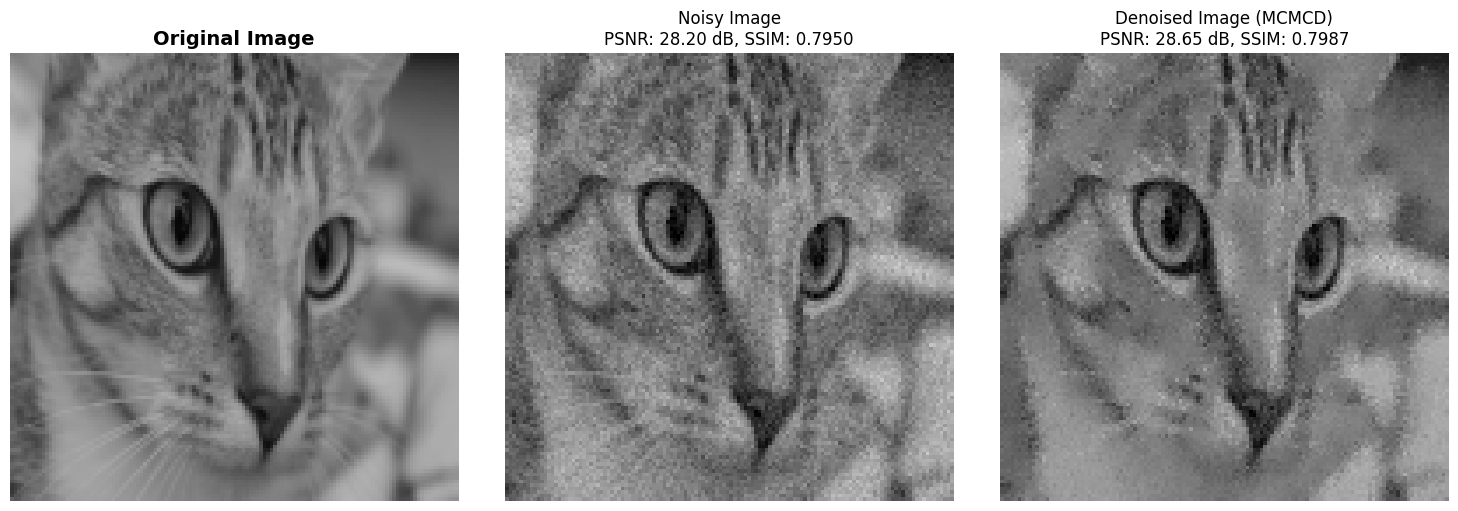

In [43]:
def generate_test_image(size=128, pattern='camera'):
    """
    Generate test images from scipy.datasets and other sources
    
    Parameters:
    -----------
    size : int
        Image size (will be resized to size x size)
    pattern : str
        Image type: 'camera', 'astronaut', 'coins', 'moon', 'text', 'checkerboard'
    """
    from scipy import datasets, ndimage
    from skimage import transform, color, util, data
    
    if pattern == 'camera':
        # Camera image (512x512 grayscale)
        image = datasets.face(gray=True)
        
    elif pattern == 'astronaut':
        # Astronaut image (needs conversion to grayscale)
        image = data.astronaut()
        
    elif pattern == 'moon':
        image = data.moon()
        
    elif pattern == 'chelsea':
        image = data.chelsea()
        image = color.rgb2gray(image) * 255.0
    elif pattern == 'horse':
        image = data.horse()
        image = util.img_as_float(image) * 255.0
    
    else:
        # Default to ascent image
        image = datasets.ascent()
    
    # Resize to desired size
    if image.shape != (size, size):
        from skimage import transform
        image = transform.resize(image, (size, size), anti_aliasing=True, preserve_range=True)
    
    return np.clip(image, 0, 255)


def add_gaussian_noise(image, sigma):
    """Add Gaussian noise to image"""
    noise = np.random.normal(0, sigma, image.shape)
    noisy = image + noise
    return np.clip(noisy, 0, 255)

from skimage.metrics import structural_similarity, peak_signal_noise_ratio

def image_similarity(img1, img2):
    ssim_score, _ = structural_similarity(img1, img2, full=True)
    psnr_score = peak_signal_noise_ratio(img1, img2)
    return ssim_score, psnr_score


def test_denoising(image_size=128, noise_sigma=5, pattern='chelsea'):
    """
    Test MCMCD denoising on test image
    
    Parameters:
    -----------
    image_size : int
        Size of test image
    noise_sigma : float
        Standard deviation of Gaussian noise
    pattern : str
        Image type: 'camera', 'astronaut', 'coins', 'moon', 'text', 'checkerboard'
    """
    print(f"\n{'='*60}")
    print(f"MCMCD Denoising Test")
    print(f"{'='*60}")
    
    # Generate original image
    print(f"\n1. Generating {pattern} test image ({image_size}x{image_size})...")
    original = generate_test_image(image_size, pattern)
    print(original[2][2])
    
    # Add noise
    print(f"2. Adding Gaussian noise (σ = {noise_sigma})...")
    noisy = add_gaussian_noise(original, noise_sigma)
    
    # Denoise
    print(f"3. Denoising with MCMCD...")
    denoiser = MCMCDDenoiser(noisy, sigma_s=21, region_radius=3, num_iterations=50)
    
    start_time = time.time()
    denoised = denoiser.denoise(verbose=True)
    elapsed_time = time.time() - start_time

    noisy = noisy.astype(np.uint8)
    denoised = denoised.astype(np.uint8)
    
    # Calculate metrics
    psnr_noisy = peak_signal_noise_ratio(original, noisy, data_range=255)
    psnr_denoised = peak_signal_noise_ratio(original, denoised, data_range=255)
    
    ssim_noisy = structural_similarity(original, noisy, data_range=255)
    ssim_denoised = structural_similarity(original, denoised, data_range=255)
    
    print(f"\n{'='*60}")
    print(f"Results:")
    print(f"{'='*60}")
    print(f"Processing time: {elapsed_time:.2f} seconds")
    print(f"\nNoisy Image:")
    print(f"  PSNR: {psnr_noisy:.2f} dB")
    print(f"  SSIM: {ssim_noisy:.4f}")
    print(f"\nDenoised Image:")
    print(f"  PSNR: {psnr_denoised:.2f} dB")
    print(f"  SSIM: {ssim_denoised:.4f}")
    print(f"\nImprovement:")
    print(f"  ΔPSNR: +{psnr_denoised - psnr_noisy:.2f} dB")
    print(f"  ΔSSIM: +{ssim_denoised - ssim_noisy:.4f}")
    ssim_comp, psnr_comp = image_similarity(noisy, denoised)
    print(f"SSIM: {ssim_comp:.4f}, PSNR: {psnr_comp:.2f} dB")
    
    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original, cmap='gray', vmin=0, vmax=255)
    axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(noisy, cmap='gray', vmin=0, vmax=255)
    axes[1].set_title(f'Noisy Image\nPSNR: {psnr_noisy:.2f} dB, SSIM: {ssim_noisy:.4f}', 
                      fontsize=12)
    axes[1].axis('off')
    
    axes[2].imshow(denoised, cmap='gray', vmin=0, vmax=255)
    axes[2].set_title(f'Denoised Image (MCMCD)\nPSNR: {psnr_denoised:.2f} dB, SSIM: {ssim_denoised:.4f}', 
                      fontsize=12)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return original, noisy, denoised


# Example usage
if __name__ == "__main__":
    # Test with different images and noise levels
    print("Running MCMCD Denoising Tests\n")
    
    # Test 1: Camera/Face image with moderate noise
    test_denoising(image_size=128, noise_sigma=10, pattern='chelsea')
    
    # Uncomment to test other images:
    # test_denoising(image_size=128, noise_sigma=25, pattern='astronaut')
    # test_denoising(image_size=128, noise_sigma=20, pattern='coins')
    # test_denoising(image_size=128, noise_sigma=30, pattern='moon')
    # test_denoising(image_size=128, noise_sigma=20, pattern='text')
    # test_denoising(image_size=128, noise_sigma=25, pattern='checkerboard')